# Overfit e Underfit

Neste estudo, usaremos a API [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras?hl=pt-br), onde podemos saber mais no [guia TensorFlow Keras](https://www.tensorflow.org/guide/keras?hl=pt-br).

Nos estudo anteriores, vimos que a precisão do nosso modelo com os dados de validação atinge o pico máximo depois do treino por várias épocas e então estagnaria ou diminuiria.

Em outras palavras, nosso modelo se *ajusta* aos dados de treino, logo, resolver o problema do *overfitting* é de suma importância para o desenvolvimento do modelo. Mesmo que diversas vezes seja difícil obter alta precisão com os dados de treino, o que queremos mesmo é criar modelos que generalizem bem para um conjunto de teste, dados que o modelo nunca viu.

O *underfitting* é o oposto do *overfittin*. O *underfitting* acontece quando ainda existe espaço para melhorias nos dados de treino. Isso pode ocorrer por diversos motivos: o modelo pode não ser poderoso o suficiente, está muito regularizado ou não teve tempo de treino suficiente. Isso significa que a rede não aprendeu os padrões relevantes nos dados de treino.

Contudo, se deixarmos o modelo treinar por muito tempo, ele começa a se ajustar demais e aprenderá padrões nos dados de treino que não generalizam muito bem nos dados de teste. Saber como treinar o modelo com um número apropriado de épocas é de suma importância para o desenvolvimento do melhor modelo.

Para evitar o *overfitting*, a melhor saída é utilizar os dados de treino mais completos. A base de dados deve cobrir toda a gama de entrada que o modelo deve manipular. Dados adicionais só são úteis se abrangem novos casos e interessantes.

Um modelo treinado com dados mais completos naturalmente generalizará melhor. Quando isso não for possível, a próxima escolha é utilizar técnicas como a regularização. Porém, isso impõem restrições à quantidade e ao tipo de informação que o nosso modelo pode armazenar. Se uma rede puder somente guardar um pequeno número de padrões, o processo de otimização a forçará a se concentrar nos padrões mais proeminentes, que possuem mais chances de generalizar melhor.

Neste estudo, veremos diversas técnicas comuns de regularização e as usaremos para aprimorar um modelo de classificação.

## Configurar

Antes de começar o nosso estudo, vamos importar a bibliotecas necessárias:

In [1]:
# Instalar o pacote "tensorflow_docs"
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-0e9pxxra
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-0e9pxxra
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180247 sha256=9b20265b73dda2615e49c9687f0dabd5ecf331565802c53c9642b7fa239c81a0
  Stored in directory: /tmp/pip-ephem-wheel-cache-ob4jiexk/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [2]:
# Importar as bibliotecas
import shutil
import pathlib
import tempfile
import numpy as np
import tensorflow as tf
from IPython import display
import tensorflow_docs.plots
import tensorflow_docs.modeling
import matplotlib.pyplot as plt
import tensorflow_docs as tfdocs
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# Mostrar a versão do TensorFlow
print(tf.__version__)

2.8.2


In [3]:
# Criar um diretório temporário
logdir = pathlib.Path(tempfile.mkdtemp())/'tensorboard_logs'
shutil.rmtree(logdir, ignore_errors=True)

## O conjunto de dados de Higgs

O objetivo desse estudo não é a física de partículasm logo, não estude a fundo os dados. Esse conjunto possui 11 milhões de exemplos, cada um com 28 features e um rótulo de classe binária:

In [4]:
# Baixar os dados
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816417792/2816407858 [==============================] - 61s 0us/step


In [5]:
# Determinar a quantidade de features
FEATURES = 28

A classe [tf.data.experimental.CsvDataset](https://www.tensorflow.org/api_docs/python/tf/data/experimental/CsvDataset?hl=pt-br) pode ser utilizada para ler os registro de arquivos `.csv` diretamente de uma arquivo `gzip` sem precisar descompatar o arquivo:

In [6]:
# Obter o arquivo .csv sem descompactar o gzip
conjunto_dados = tf.data.experimental.CsvDataset(gz,
                                                 [float(),]*(FEATURES+1),
                                                 compression_type='GZIP')

Essa classe de leitor de arquivos `.csv` retorna uma lista de escalares para cada registro. A função mostrada na célula abaixo reempacota essa lista de escalares em um par `(vetor_feature, rótulo)`:

In [7]:
# Criar a função de reempacotamento
def empacotar_linha(*linha):
  rotulo = linha[0]
  features = tf.stack(linha[1:], 1)
  return features, rotulo

O TensorFlow trabalha melhor quando opera em grandes lotes de dados.

Logo, ao invés de reempacotar cada linha de modo indiviual, criaremos um novo conjunto de dados que receba lotes de 10 mil exemplos, aplicaremos a função **empacotar_linha()** a cada lote e, em seguida, dividiremos os lotes em registros individuais:

In [8]:
# Reempacotar o conjunto de dados
pacote_dados = conjunto_dados.batch(10**4).map(empacotar_linha).unbatch()

Vejamos alguns registros de **pacote_dados**. As features não estão normalizadas, mas já é o bastante para este estudo:

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


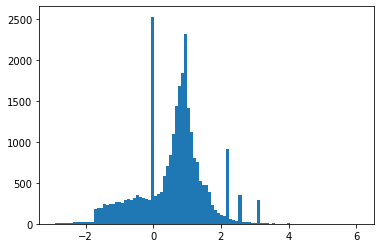

In [9]:
# Analisar como os registros estão distribuídos
for features, rotulo in pacote_dados.batch(10**3).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins=101)

Como o objetivo deste estudo é o *underfitting* e o *overfitting*, usaremos apenas as primeiras mil amostrar para validação e as próximas 10 mil para o treino:

In [10]:
TAMANHO_VALIDACAO = int(1e3)
TAMANHO_TREINO = int(1e4)
TAMANHO_BUFFER = int(1e4)
TAMANHO_LOTE = 500
PASSO_POR_EPOCA = TAMANHO_TREINO//TAMANHO_BUFFER

Os métodos [Dataset.skip](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=pt-br#skip) e [Dataset.take](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=pt-br#take) faciltam o nosso estudo.

Ao mesmo tempo, usaremos o método [Dataset.cache](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=pt-br#cache) para garantir que o carregar não precise reler todos os dados de arquivo a cada época:

In [11]:
# Separar os dados de treino e validação
dados_validacao = pacote_dados.take(TAMANHO_VALIDACAO).cache()
dados_treino = pacote_dados.take(TAMANHO_VALIDACAO).take(TAMANHO_TREINO).cache()

In [12]:
dados_treino

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

Esses conjuntos de dados retornam exemplos individuais. Usaremos o método **.batch()** para criar lotes de tamanho apropriado para o treino. Antes de fazer os lotes, lembre-se de usar os métodos **.shuffle()** e **.repeat()** nos dados de treino:

In [13]:
# Criar os lotes
dados_validacao = dados_validacao.batch(TAMANHO_LOTE)
dados_treino = dados_treino.shuffle(TAMANHO_LOTE).repeat().batch(TAMANHO_LOTE)

## Demonstrar sobreajuste

A forma mais cimples de evitar o *overfitting* é começar com um modelo pequeno: um modelo pequeno com um número de parâmetros apreensíveis (determinado pelo número de camadas e o número de unidades por camada). No aprendizado profundo, o número de parâmetros que pode ser aprendidos em um modelo é geralmente chamado de *capacidade* do modelo.

Seguindo a lógica, um modelo com mais parâmetros terá mais *capacidade de memorização* e, logo, poderá aprender facilmente um mapeamento perfeito do tipo dicionário entre amostras de treino e seus alvos, um mapeamento sem nenhuma generalização, sendo algo inútil para as previsões de dados nunca vistos pelo modelo.

Sempre pense nisso: os modelos de aprendizado profundo tendem a serem bons em se ajustar aos dados de treino, mas o real desafio é a generalização, não o ajuste.

Por outro lado, se a rede tiver recursos de memorização limitados, ele não consegurá aprender o mapeamento com tanta facilidade. Para diminuir essa perda, o modelo deverá aprender representações compactas que possuam mais poder preditivo. Ao mesmo tempo, se tornarmos nosso modelo muito pequeno, ele terá dificuldades em ajustr-se aos dados de treino. Existe um equilíbrio entre *capacidade demais* e *capacidade insuficiente*.

Infelizmente, ainda não descobriram uma fórmula mágica para estimar o tamanho correto ou a arquitetura de um modelo (número de camadas e tamanho certo para cada camada). Teremos de experimentar uma série de arquiteturas diferentes.

Para saber qual o tamanho apropriado para o modelo, é bom começar com poucas camadas e parâmetros, para depois começar a aumentar o tamanho das camadas ou adicionar novas até que haja perda nos valores da validação.

Começaremos com um modelo simples utilizando apenas [layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense?hl=pt-br) como ponto de partida:

### Procedimento de treinamento

Diversos modelos treinam melhor se reduzirmos gradualmente a taxa de aprendizado durante o treino. Para isso, usaremos [optimizers.schedules](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules?hl=pt-br) para reduzir a taxa de aprendizado ao longo do tempo:

In [14]:
# Reduzir a taxa de aprendizado ao longo do tempo
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=PASSO_POR_EPOCA*1000,
    decay_rate=1,
    staircase=False
)

def obter_otimizador():
  return tf.keras.optimizers.Adam(lr_schedule)

O código na célula acima define um [schedule.InverseTimeDecay](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/InverseTimeDecay?hl=pt-br) para diminuir de modo hiperbólico a taxa de aprendizado para 1/2 da taxa básica em mil épocas, 1/3 em 2 mil épocas e assim por diante:

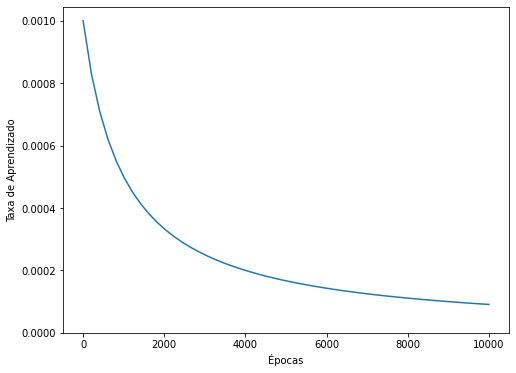

In [15]:
# Plotar um gráfico da curva de aprendizado
passo = np.linspace(0, 10**4)
taxa_aprendizado = lr_schedule(passo)
plt.figure(figsize=(8, 6))
plt.plot(passo/PASSO_POR_EPOCA, taxa_aprendizado)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Épocas')
_ = plt.ylabel('Taxa de Aprendizado')

Cada modelo neste estudo utilizará a mesma configuração de treino. Logo, os configuraremos de maneira reutilizável, começando com a lista de retornos de chamada.

O treino para este estudo é executado por várias épocas curtas. Para diminuir o ruído de log, usaremos `tfdocs.EpochDots` que imprime um arquivo `.` para cada época e um conjunto completo de métricas a cada 100 épocas.

Depois, icluiremos [callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping?hl=pt-br) para evitar tempos de treino longo e desnecessários. Note que esse retorno de chamada é definido para monitorar o **val_binaty_crossentropy** e não o **val_loss**. Essa diferença será útil mais tarde.

Usaremos [callbacks.TensorBoard](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard?hl=pt-br) para gerar logs do TensorBoard para o treino:

In [16]:
# Criar a função de callback
def obter_callbacks(nome):
  return [
          tfdocs.modeling.EpochDots(),
          tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy',
                                           patience=200),
          tf.keras.callbacks.TensorBoard(logdir/nome)
  ]

Do mesmo modo, cada modelo utilizará as mesmas configurações de [compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model?hl=pt-br#compile) e [fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model?hl=pt-br#fit):

In [28]:
# Criar a função para compilar e treinar o modelo
def compilar_treinar(modelo, nome, otimizador=None, max_epocas=10**4):
  if otimizador is None:
    otimizador = obter_otimizador()

  modelo.compile(optimizer=otimizador,
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics=[
                          tf.keras.losses.BinaryCrossentropy(
                              from_logits=True, name='binary_crossentropy'),
                          'accuracy'])
  
  modelo.summary()

  historia = modelo.fit(
      dados_treino,
      steps_per_epoch=PASSO_POR_EPOCA,
      epochs=max_epocas,
      validation_data=dados_validacao,
      callbacks=obter_callbacks(nome),
      verbose=0
  )

  return historia

### Modelo minúsculo

Começaremos com o treino do modelo:

In [18]:
# Criar o modelo
modelo_minusculo = tf.keras.Sequential([
                    layers.Dense(16,
                                 activation='elu',
                                 input_shape=(FEATURES,)),
                    layers.Dense(1)
])

In [19]:
# Criar um dicionário para armazenar o histórico
tamanho_historico = {}

In [29]:
# Armazenar o histórico do modelo minúsculo
tamanho_historico['Minusculo'] = compilar_treinar(modelo_minusculo, 'tamanho/minusculo')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.7700,  binary_crossentropy:0.4279,  loss:0.4279,  val_accuracy:0.7870,  val_binary_crossentropy:0.4405,  val_loss:0.4405,  
....................................................................................................
Epoch: 100, accuracy:0.7900,  binary_crossentropy:0.4395,  loss:0.4395,  val_accuracy:0.7840,  val_binary_crossentropy:0.4348,  val_loss:0.4348,  
............................................................

Vejamos como ficou o modelo:

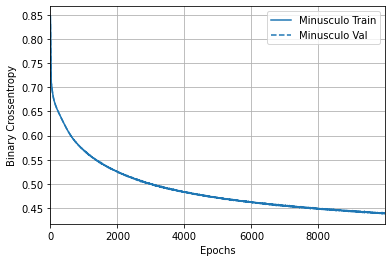

In [22]:
# Plotar um gráfico para ver a curva de aprendizado
plotagem = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)
plotagem.plot(tamanho_historico)

### Modelo pequeno

Vejamos se conseguimos superar o desempenho do modelo minúsculo.

Experimentemos usar duas *hidden units* com 16 neurônios cada:

In [23]:
# Criar o modelo
modelo_pequeno = tf.keras.Sequential([
                                      layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(1)
])

In [24]:
# Armazenar o histórico do modelo pequeno
tamanho_historico['Pequeno'] = compilar_treinar(modelo_pequeno, 'tamanho/pequeno')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4220,  binary_crossentropy:0.7815,  loss:0.7815,  val_accuracy:0.4620,  val_binary_crossentropy:0.7559,  val_loss:0.7559,  
....................................................................................................
Epoch: 100, accuracy:0.5000,  binary_crossentropy:0.6648,  loss:0.6648,  

### Modelo médio

Usaremos agora 3 *hidden units* com 64 neurônios cada:

In [26]:
# Criar o modelo
modelo_medio = tf.keras.Sequential([
                                    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
                                    layers.Dense(64, activation='elu'),
                                    layers.Dense(64, activation='elu'),
                                    layers.Dense(1)
])

In [27]:
# Armazenar o histórico do modelo médio
tamanho_historico['Medio'] = compilar_treinar(modelo_medio, 'tamanho/medio')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1856      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4460,  binary_crossentropy:0.8394,  loss:0.8394,  val_accuracy:0.4610,  val_binary_crossentropy:0.7558,  val_loss:0.7558,  
....................................